In [334]:
import os
import glob
import re
import pydot
import graphviz
import pandas as pd
import spacy
import numpy as np
from PIL import Image
from pickle import dump
from pickle import load
from tqdm import tqdm
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from nltk.translate.bleu_score import corpus_bleu
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
from tensorflow.keras.utils import load_img, img_to_array, to_categorical, plot_model

In [2]:
class Image_preprocess:
    def __init__(self,image_loc):
        self.image_loc = image_loc
        self.images = [img for img in tqdm(glob.glob(self.image_loc))]
        self.image_features = {}
        self.model = VGG16()
        self.model = Model(inputs=self.model.inputs, outputs=self.model.layers[-2].output)
        
    def get_image_features(self, image, img_name):
        feature = self.model.predict(image, verbose=0)
        img_id = img_name.split('\\')[1]
        img_id = img_id.split('.')[0]
        self.image_features[img_id] = feature
        return
    
    def preprocess_image(self):
        for img_name in tqdm(self.images,print('Progress for extracting features')):
            image = load_img(img_name ,target_size=(224, 224))
            image = img_to_array(image)
            image = image.reshape((1, image.shape[0],image.shape[1],image.shape[2]))
            image = preprocess_input(image)
            self.get_image_features(image, img_name)
        return self.image_features
            
    def show_data(self):
        print(self.image_features)
            

In [ ]:
image_loc = 'C:/Users/Neil/Downloads/DL_dataset/Flicker8k_Dataset/*.jpg'
data = Image_preprocess(image_loc)
image_features = data.preprocess_image()
data.show_data()

In [298]:
class Caption_preprocess:
    def __init__(self,caption_loc):
        self.caption_loc = caption_loc
        self.caption = pd.DataFrame(pd.read_csv(self.caption_loc))
        self.tokenizer = spacy.load("en_core_web_sm")
        self.word2vec = {"pad": 0, "start": 1, "end": 2, "unkwn": 3}
        self.vec2word = {0: "pad", 1: "start", 2: "end", 3: "unkwn"}
        self.tokenized_data = {}
        self.count = 4
        self.pad_length = 0
        
    def build_vocabulary(self):
        for txt in tqdm(self.caption['caption'],print('Building dictionary')):
            temp = list(self.tokenizer(txt.lower()))
            if len(temp) > self.pad_length:
                self.pad_length = len(temp) 
            for t in temp:
                if str(t) not in self.word2vec:
                    self.word2vec.update({str(t):self.count})
                    self.vec2word.update({self.count:str(t)})
                    self.count += 1
        return self.word2vec,self.vec2word
                                                                   
    def tokenize_whole_dataset(self):
        image_name = [image.split('.')[0] for image in self.caption['image']]
        caption = self.caption['caption']
        for idx in tqdm(range(caption.shape[0]),print('tokenizing the whole dataset')):
            if image_name[idx] not in self.tokenized_data:
                self.tokenized_data[image_name[idx]] = []
            self.tokenized_data[image_name[idx]].append(self.tokenize(caption[idx]))
        return self.tokenized_data
                    
    def tokenize(self,sentence):
        output = []
        temp = list(self.tokenizer(sentence.lower()))
        temp = ["start"] + temp + ["end"]
        for t in temp:
            output.append(self.word2vec[str(t)])
        return output

    def detokenize(self,sentence):
        output = []
        for t in temp:
            output.append(self.vec2word[t])
        return output
                

    def show_data(self):
        print(len(self.word2vec) - 4)
        print(self.pad_length)
        print(self.tokenized_data)
        i = 0
        for key in self.word2vec.keys():
            if i != 10:
                print(self.word2vec[key])
                print(self.vec2word[self.word2vec[key]])
            else:
                break
            i += 1 


In [ ]:
caption_loc = 'Flickr8k_text/captions.txt'
text = Caption_preprocess(caption_loc)
word2vec, vec2word = text.build_vocabulary()
image_caption = text.tokenize_whole_dataset()
text.show_data()

In [149]:
class Data_manager():
    def __init__(self, image_caption,image_feature,max_length,vocab_size,batch_size):
        self.image_caption = image_caption
        self.image_feature = image_feature
        self.max_length = max_length
        self.vocab_size = vocab_size
        self.batch_size = batch_size
        
    def train_test_split(self):
        image_data = [(img.split('\\')[1]).split('.')[0] for img in tqdm(glob.glob('Flicker8k_Dataset/*.jpg'))]
        train = image_data[:int(0.8*len(image_data))]
        test = image_data[int(0.8*len(image_data)):]
        return train,test
        
        
    def batch_data(self,train):
        x1,x2,y = [],[],[]
        n = 0
        while 1:
            for idx in train:
                n += 1
                captions = image_caption[idx]
                for caption in captions:
                    for i in range(1,len(caption)):
                        sequence1 = caption[:i]
                        sequence2 = caption[i]
                        sequence1 = pad_sequences([sequence1],self.max_length)[0]
                        sequence2 = to_categorical([sequence2],self.vocab_size)[0]
                        x1.append(self.image_feature[idx][0])
                        x2.append(sequence1)
                        y.append(sequence2)
                if n == self.batch_size:
                    x1 , x2, y = np.array(x1),np.array(x2),np.array(y)
                    yield [x1,x2], y
                    x1,x2,y = [],[],[]
                    n = 0

In [ ]:
obj4 = Data_manager(image_caption,image_features,42,8505,32)
train,test = obj4.train_test_split()


In [151]:
class Lstm_model:
    def __init__(self,vocab_size,max_length):
        self.vocab_size = vocab_size
        self.max_length = max_length
    
    def model(self):
        input_layer_1 = Input(shape=(4096,))
        image_feature_layer_1 = Dropout(0.5)(input_layer_1)
        image_feature_layer_2 = Dense(256, activation='relu')(image_feature_layer_1)
        input_layer_2 = Input(shape=(self.max_length,))
        sequence_layer_1 = Embedding(self.vocab_size, 256, mask_zero=True)(input_layer_2)
        sequence_layer_2 = Dropout(0.4)(sequence_layer_1)
        sequence_layer_3 = LSTM(256)(sequence_layer_2)
        decoder_layer_1 = add([image_feature_layer_2 , sequence_layer_3])
        decoder_layer_2 = Dense(self.vocab_size, activation='relu')(decoder_layer_1)
        output_layer = Dense(self.vocab_size, activation='softmax')(decoder_layer_2)
        model = Model(inputs=[input_layer_1,input_layer_2], outputs = output_layer)
        model.compile(loss='categorical_crossentropy', optimizer='adam')
        return model
        
        
        

In [152]:
obj = Lstm_model(8505,42)
model = obj.model()
model.summary()

Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_27 (InputLayer)           [(None, 42)]         0                                            
__________________________________________________________________________________________________
input_26 (InputLayer)           [(None, 4096)]       0                                            
__________________________________________________________________________________________________
embedding_12 (Embedding)        (None, 42, 256)      2177280     input_27[0][0]                   
__________________________________________________________________________________________________
dropout_24 (Dropout)            (None, 4096)         0           input_26[0][0]                   
___________________________________________________________________________________________

In [161]:
epochs = 30
batch_size = 64
steps = len(train) // batch_size

for i in range(epochs):
    generator = obj4.batch_data(train)
    model.fit(generator , epochs=1, steps_per_epoch = steps, verbose=1)
    model.save('final_sub_modelnumber' + str(i) + '.h5')

101/101 [==============================] - 69s 680ms/step - loss: 3.2362


D:\anaconda\envs\tensorflow\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


101/101 [==============================] - 69s 680ms/step - loss: 0.7861


In [155]:
model.save('final_sub_model_' + str(i) + '.h5')

D:\anaconda\envs\tensorflow\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [361]:
class model_evaluation:
    def __init__(self,word2vec,vec2word,image_caption,image_feature,model,caption_object):
        self.word2vec = word2vec
        self.vec2word = vec2word
        self.image_caption = image_caption
        self.image_feature = image_feature
        self.max_length = 42
        self.caption_object = caption_object
        self.model = model
        self.actual = []
        self.predicted = []
        
    def generate_caption(self,image):
        predicted_sequence = "start"
        for idx in range(self.max_length):
            sequence1 = [word2vec[word] for word in predicted_sequence.split(" ")]
            sequence1 = pad_sequences([sequence1],self.max_length)
            prediction = model.predict([image, sequence1], verbose=0)
            prediction = np.argmax(prediction)
            prediction = vec2word[prediction]
            if prediction is None:
                break
            predicted_sequence += " " + str(prediction)
            
            if prediction == "end":
                break
        return predicted_sequence

        
    def evaluate(self,test):
        for idx in tqdm(test[1:]):
            temp = []
            captions = self.image_caption[idx]
            prediction = self.generate_caption(self.image_feature[idx])
            for caption in captions:
                temp = [vec2word[word] for word in caption]
            self.actual.append(temp)
            self.predicted.append(prediction)
        self.score_model()
        
    def score_model(self):
        print("BLEU-1: %f" % corpus_bleu(self.actual, self.predicted, weights=(1.0, 0, 0, 0)))
        print("BLEU-2: %f" % corpus_bleu(self.actual, self.predicted, weights=(0.5, 0.5, 0, 0)))
        print("BLEU-1: %f" % corpus_bleu(self.actual, self.predicted, weights=(0.3, 0.3, 0.3, 0)))
        print("BLEU-2: %f" % corpus_bleu(self.actual, self.predicted, weights=(0.25, 0.25, 0.25, 0.25)))
        
    def personal_test(self,image_name):
        image_id = image_name.split('.')[0]
        img_path = os.path.join('C:/Users/Neil/Downloads/DL_dataset/Flicker8k_Dataset', image_name)
        image = Image.open(img_path)
        captions = self.image_caption[image_id]
        print('---------------------Actual---------------------')
        for caption in captions:
            temp = [self.vec2word[word] for word in caption]
            print(' '.join(temp))
        # predict the caption
        prediction = self.generate_caption(self.image_feature[image_id])
        print('--------------------Predicted--------------------')
        print(prediction)
        plt.imshow(image)
    
            

            
        

In [ ]:
obj6 = model_evaluation(word2vec,vec2word,image_caption,image_features,model,text)
obj6.evaluate(test)

---------------------Actual---------------------
start a brown dog about to jump on a smaller black and tan dog end
start large dog playing with smaller dog end
start two dogs are playing together outside . end
start two dogs playing in the grass with an adult nearby . end
start two dogs playing with each other . end
--------------------Predicted--------------------
start a brown and white dog is running around with a tan dog in the air . end


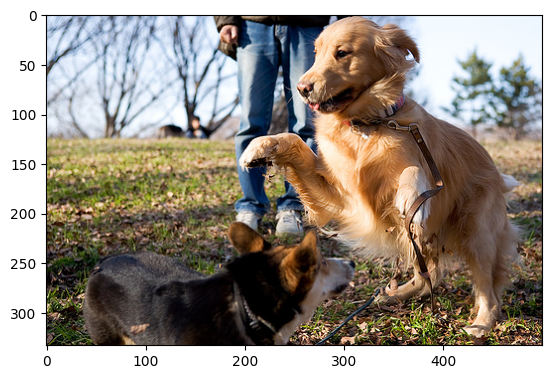

In [367]:
obj6.personal_test('387830531_e89c192b92.jpg')

---------------------Actual---------------------
start a black lab is running in a race . end
start a shiny black dog runs on the grass during a bright and sunny day . end
start the big , black , running dog is wearing a strap around its chest . end
start the black dog is running through the clearing . end
start the large black dog is running through a grassy area . end
--------------------Predicted--------------------
start a black and white dog runs in the grass . end


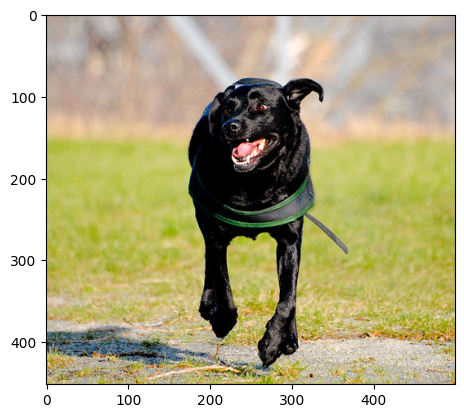

In [368]:
obj6.personal_test('393958545_48c17c66d1.jpg')